<a href="https://colab.research.google.com/github/bmullan-code/google-colab/blob/main/demo-text-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Podcats Vector Matching

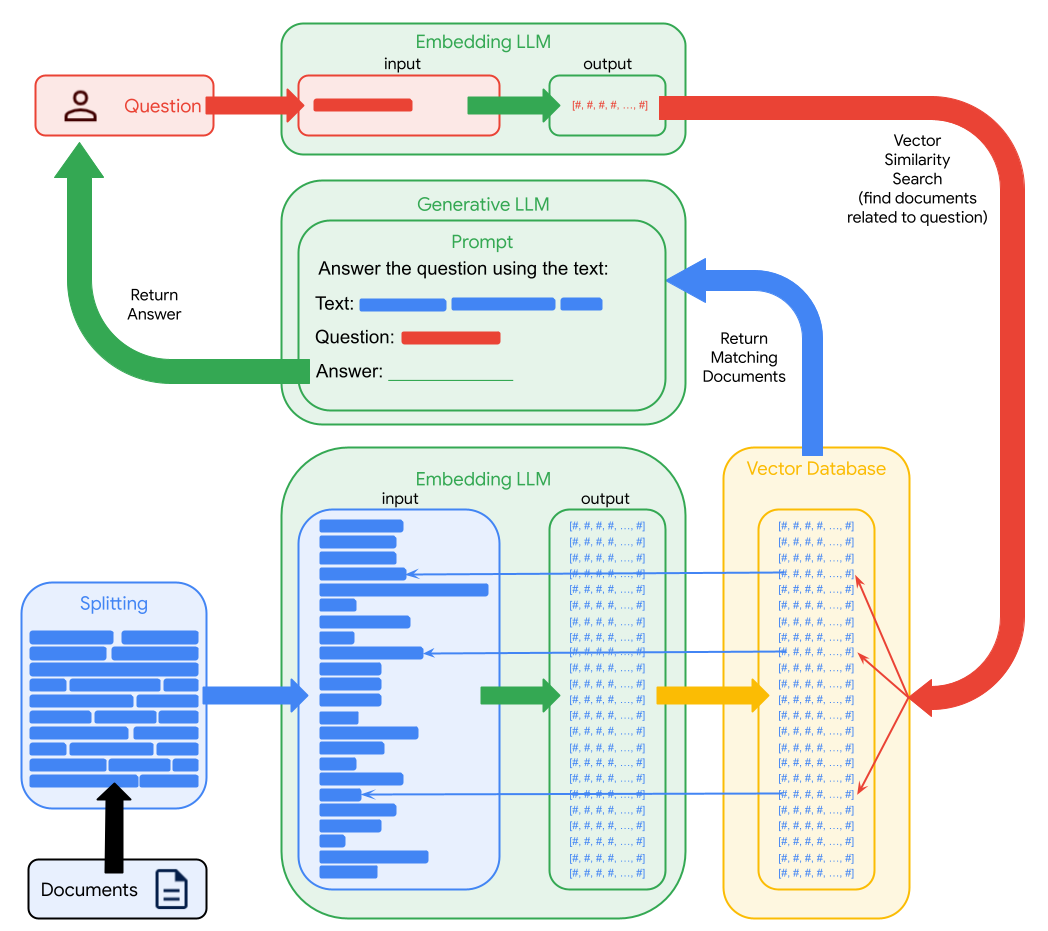

---
## Notebook Setup

In [6]:
PROJECT_ID = 'sandbox2-363416' # replace with project ID
LOCATION = 'us-central1'

In [8]:
try:
    import google.colab
    import vertexai
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    vertexai.init(project=PROJECT_ID, location=LOCATION)
except Exception:
    pass

Updated property [core/project].


---
## Installs

In [3]:
# Vertex AI GenAI Studio SDK
!pip install google-cloud-aiplatform --upgrade --user

# for working with embeddings locally
!pip install scann -q

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q
!pip install PyPDF2 -U -q
!pip install Pillow -U -q

In [9]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI FOr This Project
!gcloud services enable aiplatform.googleapis.com

**RESTART RUNTIME**

---
## Setup

Inputs

In [10]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'sandbox2-363416'

In [11]:
LOCATION = 'us'

Packages

In [12]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

# from google.cloud.aiplatform.private_preview import language_models
# from vertexai.preview.language_models import (ChatModel, InputOutputTextPair,
#                                               TextEmbeddingModel,
#                                               TextGenerationModel)
# from google.cloud.aiplatform import language_models
from vertexai.preview import language_models

from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage

Clients

In [13]:
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

In [14]:
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(PROJECT_ID)

In [15]:
bucket.name

'sandbox2-363416'

Local Storage

In [16]:
INDEX_PATH = '/bcbstn_handbook_index_2'

In [17]:
if os.path.exists(INDEX_PATH):
  print(f'Already Exists: {INDEX_PATH}')
else:
  os.makedirs(INDEX_PATH)
  print(f'Created: {INDEX_PATH}')

Created: /bcbstn_handbook_index_2


Inputs:

In [18]:
# url for the source document
source_document = 'https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf'

In [19]:
# first question to ask
question = "What if I need to be hospitalized? What steps should I take?"

---
## Vertex LLM Setup

[User Guide](https://docs.google.com/document/d/1ruSHqTspc7alqfWEpdJrQHSDSn962NNcuzC8kCQN5Q8/edit#heading=h.jvgs2e6uly1p)

In [20]:
# create links to model: embedding api and text generation
# embedding_model = language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko-001')
embedding_model = language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
# extembedding-gecko@001
textgen_model = language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [21]:
embeddings = embedding_model.get_embeddings([question])
for e in embeddings:
  v = e.values
  print(len(v), v)

768 [0.02195247821509838, 0.0181934405118227, 0.008971888571977615, 0.061070505529642105, 0.02573958784341812, -0.011586964130401611, 0.0004745886253658682, 0.016240667551755905, -0.029695045202970505, 0.018564408645033836, -0.009572125971317291, 0.013286365196108818, 0.05696316808462143, -0.05243048071861267, -0.03368202969431877, -0.03154383599758148, -0.03510037809610367, -0.041543543338775635, 0.025782814249396324, -0.026278981938958168, -0.03882472217082977, -0.010820740833878517, 0.016049275174736977, 0.023410698398947716, 0.017411503940820694, -0.07539801299571991, -0.032368097454309464, 0.02486511319875717, -0.05566458776593208, 0.02362941764295101, 0.027276910841464996, -0.003608811879530549, -0.04075802490115166, -0.03667741268873215, 0.002853423822671175, -0.01305587962269783, -0.01761002466082573, 0.013694100081920624, -0.006282932590693235, -0.021471654996275902, 0.012812023982405663, 0.010970814153552055, 0.012512232176959515, -0.00396218104287982, 0.015321828424930573, 0

Test test generation (llm) model:

In [22]:
textgen_model.predict(question)

If you need to be hospitalized, there are a few steps you should take. First, call your doctor or healthcare provider. They will be able to give you advice on the best course of action. If you need to be seen immediately, they may be able to arrange for you to be seen at an emergency room.

If you are not able to reach your doctor or healthcare provider, you can go to the emergency room of the nearest hospital. When you arrive at the emergency room, you will be seen by a triage nurse. The triage nurse will assess your condition and determine how quickly you need to be seen by a doctor.

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [ ]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/992820229952/locations/us/processors/8f085d8f19b8a9b9"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/992820229952/locations/us/processors/8f085d8f19b8a9b9:process"
create_time {
  seconds: 1683110923
  nanos: 701009000
}
default_processor_version: "projects/992820229952/locations/us/processors/8f085d8f19b8a9b9/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Document


Copy the PDF to memory:

In [ ]:
response = requests.get(source_document)

In [ ]:
type(response.content)

bytes

Split the PDF into a document per page:

In [ ]:
pdf = PyPDF2.PdfReader(io.BytesIO(response.content))

In [ ]:
len(pdf.pages)

48

In [ ]:
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

---
## Files From Previous Run on GCS
If available

In [ ]:
PRIOR_PARSE = False
if len(list(bucket.list_blobs(prefix = f'genai{INDEX_PATH}'))) > 0:
  print('Copying previous run to local...')
  !gsutil -m cp -r gs://{bucket.name}/genai{INDEX_PATH}/results.* ../{INDEX_PATH}
  !gsutil -m cp -r gs://{bucket.name}/genai{INDEX_PATH}/documents.* ../{INDEX_PATH}
  PRIOR_PARSE = True
else:
  print('No previous run available to copy over')

No previous run available to copy over


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [ ]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [ ]:
def docai_runner(p, start, raw_document):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [ ]:
if PRIOR_PARSE:
  print('Loading Prior Results')
  with open(INDEX_PATH + '/results.json', 'r') as f:
    results = [json.loads(row) for row in f.read().splitlines()]
else:
  print('No Prior Results, Parsing with Document AI')
  print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
  results = [None] * len(pdfs)
  start = time.time()
  with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
    futures = [
        executor.submit(
            docai_runner,
            p, start,
            documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
        ) for p, pdf in enumerate(pdfs)
    ]
    for future in concurrent.futures.as_completed(futures):
      #result = futures[future]
      results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

No Prior Results, Parsing with Document AI
The Expected runtime for the parsing is 0.80 minutes


In [ ]:
len(pdfs), len(results)

(48, 48)

In [ ]:
if PRIOR_PARSE:
  print('Loading Prior Documents')
  with open(INDEX_PATH + '/documents.json', 'r') as f:
    documents = [json.loads(row) for row in f.read().splitlines()]

  page_images = []
  for r, result in enumerate(results):
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)
else:
  documents = []
  page_images = []
  for r, result in enumerate(results):
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]

      vertices = []
      for vertex in table['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
      tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  row = len(documents),
                  filename = source_document.split('/')[-1]
              ),
              extras = dict(
                  #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    row = len(documents),
                    filename = source_document.split('/')[-1]
                ),
                extras = dict(
                    #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                    vertices = vertices
                )
            )
        )

len(documents)

660

In [ ]:
print(documents[300]['page_content'])

Unless otherwise provided in the Plan Document found at tn.gov/partnersforhealth/publications/
publications.html, specified as covered expenses in this handbook or required by applicable state
or federal law, the charges for the following services and supplies are excluded from coverage by the
Tennessee State Group Insurance Program.
1


In [ ]:
print(documents[300]['metadata'])

{'page': 25, 'paragraph': 2, 'row': 300, 'filename': 'blue_handbook_2022.pdf'}


---
## Get Embeddings


In [ ]:
rate_limit_minute = 150

In [ ]:
if PRIOR_PARSE:
  print('Embeddings created on previous run.')
else:
  print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
  start = time.time()
  for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

The expected run time for embeddings is 4.40 minutes


## Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [ ]:
index = np.empty((len(documents), len(documents[0]['embedding'])))
index.shape

(660, 768)

In [ ]:
for i in range(index.shape[0]):
  if documents[i]['embedding']:
    index[i] = documents[i]['embedding']
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [ ]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [ ]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [ ]:
search_index(question, 4)

[(396, 0.75757337), (314, 0.74683374), (395, 0.69583714), (398, 0.6938709)]

---
## Save To GCS For Future Runs

It can take awhile to run the parsing job above so save results for future runs of this notebook.

In [ ]:
if PRIOR_PARSE:
  print('Already on GCS, this session used a copy.')
else:
  with open(INDEX_PATH + '/results.json', 'w') as f:
    for result in results:
      f.write(json.dumps(result))
      f.write('\n')
  !gsutil -m cp {INDEX_PATH}/results.json gs://{bucket.name}/genai{INDEX_PATH}/results.json
  with open(INDEX_PATH + '/documents.json', 'w') as f:
    for doc in documents:
      f.write(json.dumps(doc))
      f.write('\n')
  !gsutil -m cp {INDEX_PATH}/documents.json gs://{bucket.name}/genai{INDEX_PATH}/documents.json

Copying file:///bcbstn_handbook_index_2/results.json [Content-Type=application/json]...
- [1/1 files][ 53.0 MiB/ 53.0 MiB] 100% Done                                    
Operation completed over 1 objects/53.0 MiB.                                     
Copying file:///bcbstn_handbook_index_2/documents.json [Content-Type=application/json]...
-
Operation completed over 1 objects/11.0 MiB.                                     


---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Checks to see if the section closest to the response/answer was included in the sections of the rules provided in the prompt.
- Prepares and presents all the information back to the user

In [ ]:
def member_bot(question, print_results = True):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    #context = "\n".join([f'Context {c}:\n' + doc.page_content for c, (doc, score) in enumerate(relevant_documentation)])
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])
    prompt = f"""
      Give a detailed answer to the question using information from the provided contexts.

      {context}

      Question:
      {question}

      Answer and Explanation:
    """

    #print(prompt)

    response = textgen_model.predict(prompt)

    likely_source = search_index(response, k=1)
    likely_document = documents[likely_source[0][0]]

    # is likely_source in relevant_documentation?
    if likely_document['page_content'] in [documents[doc[0]]['page_content'] for doc in relevant_documentation]:
      #print('likely is in relevant')
      likely = True
    else:
      #print('likely is not in relevant')
      #likely = False
      # get most relevant context instead:
      likely = True
      likely_source = relevant_documentation[0:1]
      likely_document = documents[relevant_documentation[0][0]]

    if print_results:
      display(IPython.display.Markdown("## Response"))
      display(IPython.display.Markdown("### Question"))
      display(IPython.display.Markdown(f'{question}'))
      display(IPython.display.Markdown("### Answer"))
      display(IPython.display.Markdown(f'{response}'))
      if likely:
        display(IPython.display.Markdown("### Why?"))
        display(IPython.display.Markdown(f"{likely_document['page_content']}"))
        display(IPython.display.Markdown(f"* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[0][1]:.2f}"))
        display(IPython.display.Markdown(f"* {source_document}#page={likely_document['metadata']['page']}"))
      display(IPython.display.Markdown("### Sources"))
      #display(IPython.display.Markdown("\n".join(f"* {source_document}#page={doc[0].metadata['page']}\n\t* Document: {doc[0].metadata['filename']}, page: {doc[0].metadata['page']}, relevance to question: {doc[1]:.2f}\n\t* {doc[0].page_content}" for doc in relevant_documentation)))
      display(IPython.display.Markdown("\n".join(f"* {source_document}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)))

    if likely:
      font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
      #document_image = PIL.Image.open(io.BytesIO(documents[likely_source[0][0].metadata['row']]['extras']['image']))
      document_image = page_images[likely_document['metadata']['page']-1]
      draw = PIL.ImageDraw.Draw(document_image)
      vertices = documents[likely_document['metadata']['row']]['extras']['vertices']
      draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
      ], outline = 'green')
      IPython.display.display(document_image.resize((800, 1000)))

    return

## Response

### Question

What if I need to be hospitalized? What steps should I take?

### Answer

If you need to be hospitalized, you should first contact your doctor. Your doctor will make the necessary arrangements at an in-network facility. Be sure to ask if the facility is in-network or call us to confirm. Your doctor should also coordinate your care and prior authorization with our office. If you are admitted to a hospital (in-network or out-of-network) without our prior authorization, your benefits will be greatly reduced.

### Why?

If you need to be hospitalized, your doctor should
make the necessary arrangements at an in-network
facility. Be sure to ask if the facility is in-network or
call us to confirm. Your doctor should also coordinate
your care and prior authorization with our office. If
you are admitted to a hospital (in-network or out-of-
network) without our prior authorization, your benefits
will be greatly reduced.
D

* page: 33, relevance to answer: 0.99

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=33

### Sources

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=33
	* Document: blue_handbook_2022.pdf, page: 33, relevance to question: 0.76
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=27
	* Document: blue_handbook_2022.pdf, page: 27, relevance to question: 0.75
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=33
	* Document: blue_handbook_2022.pdf, page: 33, relevance to question: 0.70
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=33
	* Document: blue_handbook_2022.pdf, page: 33, relevance to question: 0.69
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=31
	* Document: blue_handbook_2022.pdf, page: 31, relevance to question: 0.69

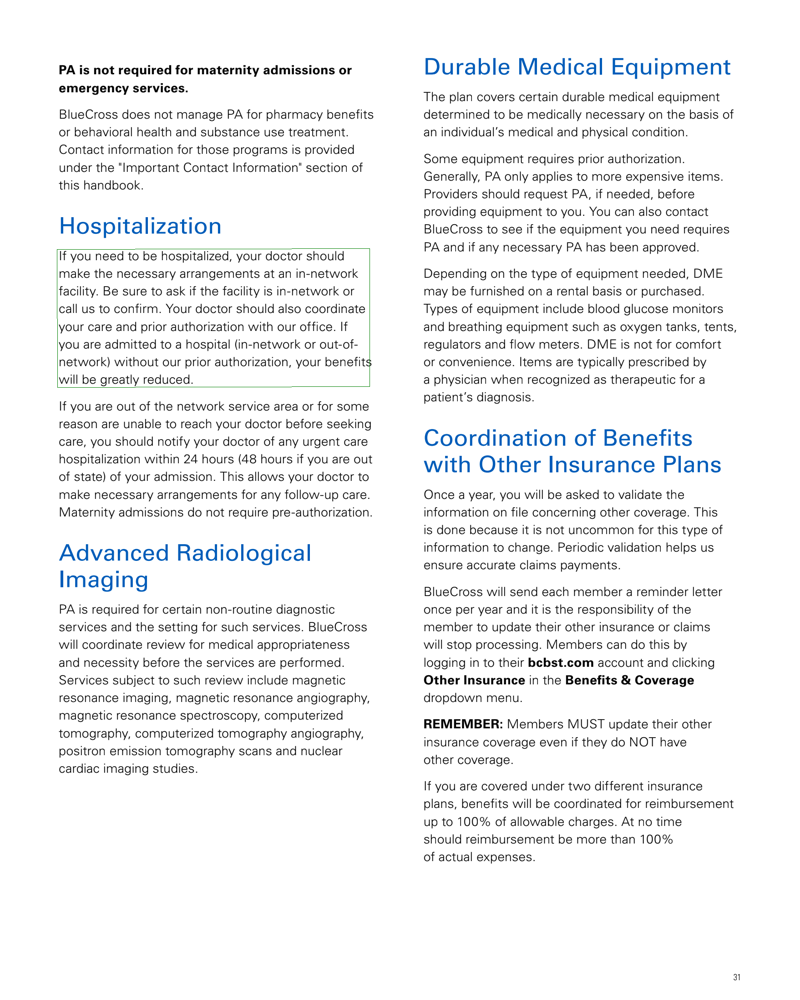

In [ ]:
member_bot(question)

## Response

### Question

What is the member cost for in-network Standard PPO plan for oral surgeons services

### Answer

The member cost for in-network Standard PPO plan for oral surgeons services is 20%.

### Why?

Plan
NIn-Network
Out-of-
Network
PProviders
(i.e., dentists,
orthodontists)
PPremier PPO
10%
40%
10%
SStandard
PPO
20%
40%
20%
LLimited PPO
30%
50%
30%
CCDHP/HSA
20%
40%
20%
LLocal
CDHP/HSA
30%
50%
30%
2

* page: 28, relevance to answer: 0.80

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=28

### Sources

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=28
	* Document: blue_handbook_2022.pdf, page: 28, relevance to question: 0.74
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=35
	* Document: blue_handbook_2022.pdf, page: 35, relevance to question: 0.73
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=14
	* Document: blue_handbook_2022.pdf, page: 14, relevance to question: 0.73
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=28
	* Document: blue_handbook_2022.pdf, page: 28, relevance to question: 0.72
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=6
	* Document: blue_handbook_2022.pdf, page: 6, relevance to question: 0.72

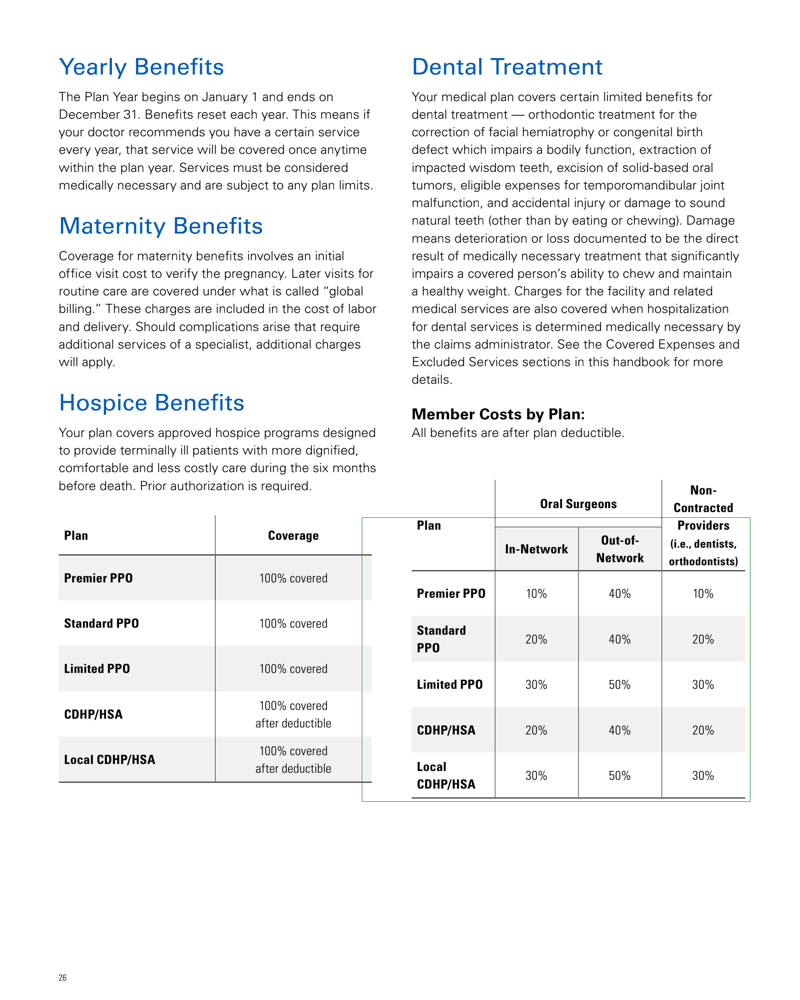

In [ ]:
member_bot("What is the member cost for in-network Standard PPO plan for oral surgeons services")

## Response

### Question

What authorizations do I need for a transplant?

### Answer

Prior authorization is required for all transplants. Your plan provides cost savings if you have an approved transplant at a BCBS Blue Distinction Center of Excellence; or an in-network approved facility if there is no BCBS Blue Distinction COE for the type of transplant you need. If you elect to have covered transplant services at another facility when there is a BCBS Blue Distinction COE option, you will pay the usual member cost share.

### Why?

Prior authorization is required for ALL transplants. Your
plan provides cost savings if you have an approved
transplant at:
A

* page: 29, relevance to answer: 0.92

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=29

### Sources

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=29
	* Document: blue_handbook_2022.pdf, page: 29, relevance to question: 0.78
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=29
	* Document: blue_handbook_2022.pdf, page: 29, relevance to question: 0.68
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=29
	* Document: blue_handbook_2022.pdf, page: 29, relevance to question: 0.68
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=10
	* Document: blue_handbook_2022.pdf, page: 10, relevance to question: 0.68
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=29
	* Document: blue_handbook_2022.pdf, page: 29, relevance to question: 0.67

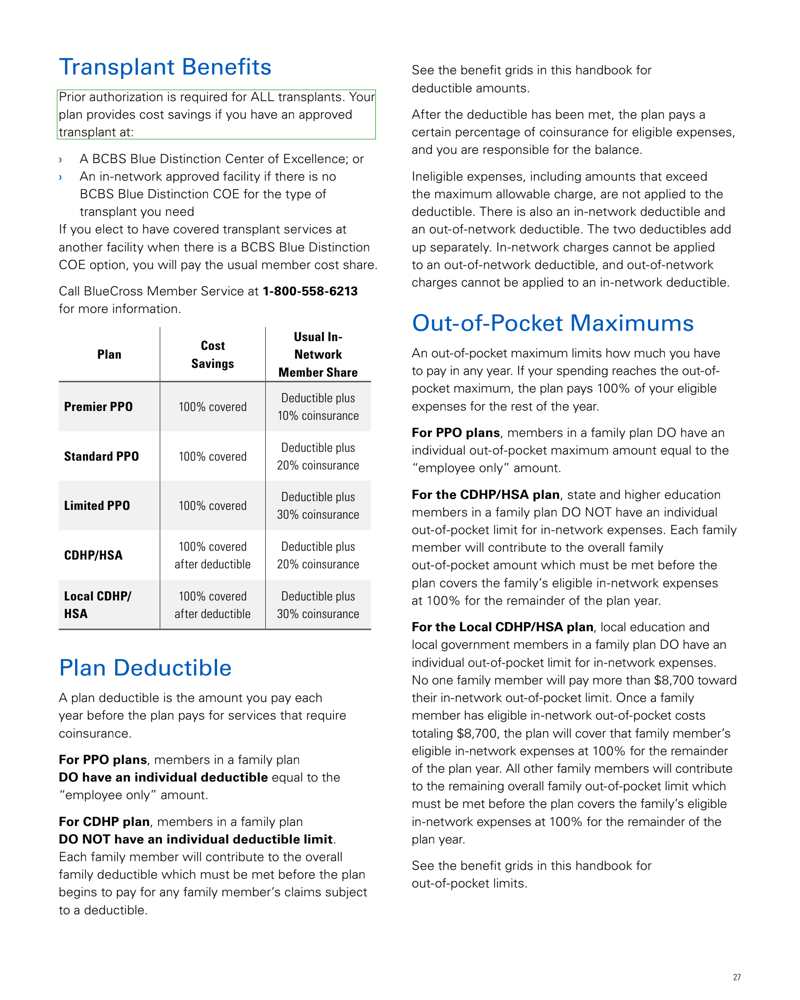

In [ ]:
member_bot("What authorizations do I need for a transplant?")

## Response

### Question

Are ear or body piercings covered?

### Answer

Ear or body piercings are not covered by the insurance plan.

The answer is in the context 1, which states that "Ear or body piercing" is not covered.

### Why?

11. Sensitivity training, educational training therapy or treatment
for an education requirement.
22. Radial keratotomy, LASIK or other procedures to correct
refractive errors; eyeglasses, sunglasses or contacts including
12. Court or employer-ordered or required examinations or care,
examinations and fitting charges.
or care in lieu of legal involvement or incarceration, unless
23. Surgery or treatment for or related to sex transformations
otherwise considered medically necessary and/or clinically
or sexual dysfunctions or inadequacies, including penile
necessary by the claims administrator.
prosthesis due to psychogenic impotence other than
13. 14. Treatment of an injury or illness due to declared
or undeclared war.
Comfort or convenience items (e.g. television, telephone,
radio, air conditioner, beauty shop and barber services,
guest meals and guest beds, bathroom chairs, stools
24. 25. psychological treatment or counseling.
Services or supplies in connection with fertility preservation,
artificial insemination, in-vitro fertilization or any procedure
intended to create a pregnancy.
Wigs.
and tub handrails).
26. Ear or body piercing.
15. Humidifiers, dehumidifiers, air filters, whirlpools, heating
pads, sun or heat lamps, air conditioners, air purifiers
and exercise devices.
27. Custodial care, unapproved sitters, day and evening care
centers (primarily for rest or for the elderly) or diapers.
16. Arch supports, corn plaster (pads, etc.), foot padding
(adhesive moleskin, etc.) orthotic or orthopedic shoes and
28. Programs considered primarily educational and materials such
as books or tapes.
other foot orthoses including inner soles or inserts, foot
29. Extraneous fees such as postage, shipping or mailing fees,
orthoses primarily used for cosmetic reasons or for improved
service tax, stat charges or collection and handling fees.
athletic performance or sports participation, and routine foot
care including charges for the removal of corns or callus or
trimming of toenails unless there is a diabetic diagnosis.
30. Drugs and supplies which can be obtained without a
prescription, including nutritional supplements, vitamins,
and oral nutritional formulas for infants and adults which
17. Garter belts and elastic stockings, except Jobst or similar
quality support hose, when medically necessary as
can be obtained at retail or over-the-counter without a
written prescription. Nutritional treatment of inborn errors of
18. determined by the claims administrator.
Hearing aids for adults 18 years and older, including
examinations and fittings.
31. metabolism, enteral nutrition and total parenteral nutrition
are not excluded.
Hotel charges unless pre-approved through the organ
transplant 19. Midwife services outside a licensed health care facility.
32. transplant program.
Cosmetic surgery and related expenses including but not
20. Nonsurgical service for weight control or reduction, including
prescription medication and weight loss programs, fitness
limited to scar revision, rhinoplasty, prosthetic penile
clubs and programs. This exclusion does not apply to certain
preferred anti-obesity medications, healthy diet counseling as
described in the covered expenses section of this handbook,
implants, saline injection of varicose veins and reconstructive
surgery where no significant anatomic functional
impairment exits.
ParT Ners for Health sponsored programs or participation
33. Dental care, treatment or oral surgery relating to the teeth
in an integrated clinical program as part of the bariatric
and gums including but not limited to dental appliances,
surgery benefit.
dental prostheses (such as crowns, bridges or dentures),
21. Organ transplants involving artificial organs and nonhuman
organ transplants, and any services or supplies in connection
implants, orthodontic care, fillings, extractions, endodontic
care, treatment of caries, gingivitis or periodontal disease.
with experimental or investigational treatment, drugs or
34. Reversal of sterilization procedures.
procedures, unless determined to be medically necessary by
the claims administrator.
35. Charges incurred outside the United States unless traveling
for business or pleasure.


* page: 26, relevance to answer: 0.69

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=26

### Sources

* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=26
	* Document: blue_handbook_2022.pdf, page: 26, relevance to question: 0.69
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=23
	* Document: blue_handbook_2022.pdf, page: 23, relevance to question: 0.65
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=25
	* Document: blue_handbook_2022.pdf, page: 25, relevance to question: 0.65
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=32
	* Document: blue_handbook_2022.pdf, page: 32, relevance to question: 0.65
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=17
	* Document: blue_handbook_2022.pdf, page: 17, relevance to question: 0.65
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=15
	* Document: blue_handbook_2022.pdf, page: 15, relevance to question: 0.65
* https://www.tn.gov/content/dam/tn/finance/fa-benefits/documents/blue_handbook_2022.pdf#page=20
	* Document: blue_handbook_2022.pdf, page: 20, relevance to question: 0.64

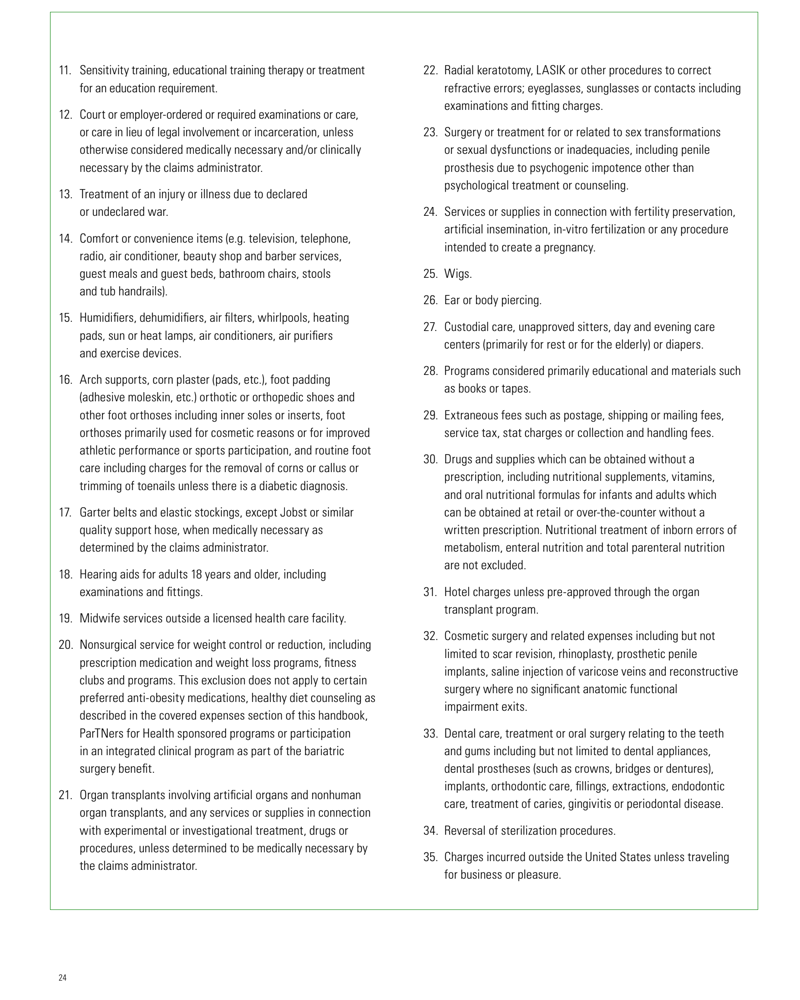

In [ ]:
member_bot("Are ear or body piercings covered?")